In [1]:
# Importing Dependencies
import numpy as np
import gym
from gym.envs.box2d.car_racing import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from statistics import mean
from pyglet.window import key
import time
from tqdm import tqdm 
import os
from keras.utils import normalize

C:\Users\Piyush\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Function for generating data by playing
def start_playing(samples):
    a = np.array( [0.0, 0.0, 0.0] )
    def key_press(k, mod):
        global restart
        if k==0xff0d: restart = True
        if k==key.LEFT:  a[0] = -1.0
        if k==key.RIGHT: a[0] = +1.0
        if k==key.UP:    a[1] = +1.0
        if k==key.DOWN:  a[2] = +0.8   
    def key_release(k, mod):
        if k==key.LEFT  and a[0]==-1.0: a[0] = 0
        if k==key.RIGHT and a[0]==+1.0: a[0] = 0
        if k==key.UP:    a[1] = 0
        if k==key.DOWN:  a[2] = 0
    
    env = CarRacing()
    env.render()
    env.viewer.window.on_key_press = key_press
    env.viewer.window.on_key_release = key_release
    collected = {'l':0,'r':0,'s':0,'b':0} 
    X = []
    y = np.array([0.,1.,0.])
    game = 0
    while True:
        prev_observation = env.reset()        
        restart = False
        while True:
            action = a
            observation, reward, done, info = env.step(action)
            X.append(prev_observation)
            y = np.vstack((y, action))
            prev_observation=observation
            if np.array_equal(action, np.array([-1,0,0])) and collected['l']<samples['l']:
                collected['l'] += 1
            elif np.array_equal(action, np.array([1,0,0])) and collected['r']<samples['r']:
                collected['r'] += 1
            elif np.array_equal(action, np.array([0,1,0])) and collected['s']<samples['s']:
                collected['s'] += 1
            elif np.array_equal(action, np.array([0,0,0.8])) and collected['b']<samples['b']:
                collected['b'] += 1    
            env.render()
            if done or restart: break
        time.sleep(2)
        if collected['l']>=samples['l'] and collected['r']>=samples['r'] and collected['s']>=samples['s'] and collected['b']>=samples['b']:
            break
        game+=1
        if game%10 == 0:
            np.save('balanced_train_X.npy', X)
            np.save('balanced_train_y.npy', y)
    X = np.array(X)        
    np.save('balanced_train_X.npy', X)
    np.save('balanced_train_y.npy', y)    
    env.close()
    return X, y

In [3]:
# Playing the to create data
samples = {'l':2000, 'r':2000, 's':2000, 'b':2000}
X, y=start_playing(samples)

Track generation: 1208..1514 -> 306-tiles track
Track generation: 1084..1359 -> 275-tiles track
Track generation: 1037..1309 -> 272-tiles track
Track generation: 1040..1304 -> 264-tiles track
Track generation: 1095..1373 -> 278-tiles track
Track generation: 1105..1386 -> 281-tiles track
Track generation: 1105..1389 -> 284-tiles track
Track generation: 1118..1402 -> 284-tiles track
Track generation: 1220..1535 -> 315-tiles track
Track generation: 1153..1453 -> 300-tiles track
Track generation: 1278..1602 -> 324-tiles track
Track generation: 1140..1429 -> 289-tiles track
Track generation: 1221..1537 -> 316-tiles track
Track generation: 1144..1434 -> 290-tiles track
Track generation: 1119..1411 -> 292-tiles track
Track generation: 1132..1419 -> 287-tiles track
Track generation: 1187..1488 -> 301-tiles track
Track generation: 1012..1269 -> 257-tiles track
Track generation: 1104..1384 -> 280-tiles track
Track generation: 998..1261 -> 263-tiles track
Track generation: 1203..1517 -> 314-tiles

In [2]:
# Loading the data
X = np.load('X_balanced_final.npy')
y = np.load('y_balanced_final.npy')
X = X.reshape(-1,96,96,3)
y = y.reshape(-1,4)
print(X.shape)
print(y.shape)

(8001, 96, 96, 3)
(8001, 4)


In [73]:
new_X = []
new_X.append(X[0])
new_y = np.array([0,0,1,0])

moves={'l':0, 'r':0, 's':0, 'b':0}


for ix, iy in tqdm(zip(X, y)):
    if np.array_equal(iy, left) and moves['l']<500:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy))
        moves['l'] += 1
    elif np.array_equal(iy, right) and moves['r']<200:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy))
        moves['r'] += 1
    elif np.array_equal(iy, straight) and moves['s']<1000:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy))
        moves['s'] += 1
    elif np.array_equal(iy, stop) and moves['b']<400:
        new_X.append(ix)
        new_y = np.vstack((new_y, iy)) 
        moves['b'] += 1

X = np.array(new_X).reshape(-1,96,96,3)
y = new_y.reshape(-1,4)
print(X.shape)
print(y.shape)     


0it [00:00, ?it/s]
6150it [00:00, 61444.10it/s]
8001it [00:00, 62450.69it/s]

(3401, 96, 96, 3)
(3401, 4)


In [4]:
# Variation in generated data
left=np.array([1,0,0,0])
right=np.array([0,1,0,0])
straight=np.array([0,0,1,0])
stop=np.array([0,0,0,1])
l=0
r=0
s=0
b=0

for key in y:
    if np.array_equal(key, left):
        l+=1
    elif np.array_equal(key, right):
        r+=1
    elif np.array_equal(key, straight):
        s+=1
    elif np.array_equal(key, stop):
        b+=1
        
print(l,r,s,b) 

2000 2000 2001 2000


In [82]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (96,96,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

In [83]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy")

In [84]:
model.fit(X, y, epochs=2, validation_split=0.2, batch_size=128, verbose=1, shuffle=True)

Train on 2720 samples, validate on 681 samples
Epoch 1/2
2720/2720 [==============================] - ETA: 42s - loss: 2.32 - ETA: 20s - loss: 2.08 - ETA: 13s - loss: 1.82 - ETA: 9s - loss: 1.6838 - ETA: 7s - loss: 1.534 - ETA: 6s - loss: 1.408 - ETA: 5s - loss: 1.302 - ETA: 4s - loss: 1.252 - ETA: 3s - loss: 1.178 - ETA: 3s - loss: 1.106 - ETA: 2s - loss: 1.032 - ETA: 2s - loss: 0.976 - ETA: 1s - loss: 0.941 - ETA: 1s - loss: 0.885 - ETA: 1s - loss: 0.844 - ETA: 0s - loss: 0.812 - ETA: 0s - loss: 0.774 - ETA: 0s - loss: 0.757 - ETA: 0s - loss: 0.725 - ETA: 0s - loss: 0.710 - ETA: 0s - loss: 0.685 - 4s 1ms/step - loss: 0.6838 - val_loss: 0.1974
Epoch 2/2
2720/2720 [==============================] - ETA: 1s - loss: 0.223 - ETA: 1s - loss: 0.205 - ETA: 1s - loss: 0.201 - ETA: 1s - loss: 0.199 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.197 - ETA: 0s - loss: 0.197 - ETA: 0s - loss: 0.204 - ETA: 0s - loss: 0.200 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.187 - ETA: 0s - loss: 0.192 - ETA:

In [2]:
# Saving the Model
model.save('Models/first_modelv2_4out_turn')

NameError: name 'model' is not defined

In [3]:
# Loading the Model
from keras.models import load_model
model = load_model('Models/first_modelv1_35_1_02_2_5')

In [4]:
#scores = []
#choices = []
env = CarRacing()
for each_game in range(5):
    #score = 0
    #game_memory = []
    prev_obs = env.reset()
    for i in range(1000):  
        env.render()
        out = model.predict(prev_obs.reshape(-1,96,96,3))[0]
             
        turn = out[1]*0.7 if out[1]>out[0] else -out[0]*0.8
        turn = np.append(turn, out[2]*5)
        turn = np.append(turn, out[3]*0.8)
        print(turn)
        new_observation, reward, done, info = env.step(turn)
        prev_obs = new_observation
        #game_memory.append([new_observation, action])
        #score+=reward
        if done: 
            break
    #scores.append(score)
    #print('Episode {} Score: {}'.format(each_game+1,score))
    env.close()
#print('Average Score:',sum(scores)/len(scores))

Track generation: 1126..1411 -> 285-tiles track
[-2.31747890e-07  1.65850704e-12  1.49112976e-14]
[0.08285948 0.00112063 0.20481088]
[2.35997537e-01 2.22067738e-04 1.28035609e-01]
[0.42309605 0.00103955 0.1000379 ]
[0.41651375 0.00069941 0.1125563 ]
[0.27402221 0.00088027 0.09112615]
[0.18946992 0.00137756 0.21538247]
[0.14274676 0.00264679 0.27891034]
[-0.29305961  0.00569133  0.1942939 ]
[-0.40010066  0.01160102  0.17303472]
[-0.40033836  0.01941528  0.14583582]
[-0.39394951  0.03112582  0.14532766]
[-0.40979695  0.04463646  0.11231865]
[-0.33580799  0.08697989  0.09864806]
[-0.35096052  0.30360863  0.13045373]
[-0.3440186   0.41759074  0.13203757]
[-0.34494946  0.38850401  0.13547069]
[-0.33251858  0.39165787  0.13489579]
[-0.31491213  0.43155458  0.12154295]
[-0.31787426  0.42519785  0.10368768]
[-0.29409277  0.45902677  0.10047691]
[-0.21796305  0.61003052  0.1166239 ]
[-0.23080435  0.70197269  0.09652303]
[-0.24723854  0.7378906   0.09035504]
[-0.25288355  0.83906874  0.08544049]

[-0.13783102  0.93672328  0.0711641 ]
[-0.20906191  0.84498145  0.06635546]
[-0.26623797  0.7291007   0.06113731]
[-0.30383098  0.69331579  0.0657391 ]
[-0.26094239  0.79968058  0.07229589]
[-0.20901172  0.9091524   0.08064507]
[-0.15232615  1.1894758   0.08784465]
[0.1561805  1.1877808  0.08421319]
[0.22723388 1.06276669 0.08514764]
[0.25753237 0.82259431 0.0887014 ]
[0.24204184 0.87892815 0.08596269]
[0.21951233 0.87272495 0.0903742 ]
[0.18988721 1.08071543 0.08635728]
[0.15180427 1.56808883 0.06862504]
[0.10875687 1.71487734 0.05629384]
[-0.19214826  1.44185111  0.05476636]
[-0.28838499  1.05940916  0.05007562]
[-0.25660157  1.28413618  0.06316239]
[-0.35084686  0.85577115  0.05163967]
[-0.3042177   1.08492322  0.05784408]
[-0.22276349  1.59397855  0.0593724 ]
[-0.16422644  1.88918859  0.06278186]
[0.10546492 2.08630443 0.05975731]
[0.14703541 1.90380022 0.07201996]
[0.19383421 1.6083841  0.0751653 ]
[0.16854042 1.9655399  0.08506828]
[0.16513841 1.59248427 0.07916366]
[0.14499495 1

[-7.99969673e-01  1.09320594e-09  2.16254984e-05]
[-7.99975681e-01  6.86861609e-10  1.52951774e-05]
[-7.99975109e-01  3.84000748e-10  1.62161947e-05]
[-7.99973965e-01  2.80528240e-10  1.81165686e-05]
[-7.99972057e-01  2.61683973e-10  2.07380399e-05]
[-7.99972630e-01  2.58675945e-10  2.20142829e-05]
[-7.99968052e-01  2.20201357e-10  2.80395157e-05]
[-7.99966908e-01  1.65752672e-10  2.97569153e-05]
[-7.99972153e-01  8.70570196e-11  2.52373882e-05]
[-7.99978352e-01  5.83333902e-11  1.89527813e-05]
[-7.99978828e-01  6.17397800e-11  1.84694352e-05]
[-7.99981594e-01  4.39575112e-11  1.48498904e-05]
[-7.99982738e-01  3.32673559e-11  1.41598061e-05]
[-7.99985600e-01  1.78391926e-11  1.11702300e-05]
[-7.99984741e-01  1.89901372e-11  1.15737581e-05]
[-7.99979115e-01  4.00801788e-11  1.69316785e-05]
[-7.99976349e-01  6.12569067e-11  2.03152498e-05]
[-7.99967670e-01  9.27044292e-11  2.83088892e-05]
[-7.99959183e-01  2.39757884e-10  3.44212513e-05]
[-7.99946117e-01  4.74350351e-10  4.59258848e-05]


[0.26882435 0.31186331 0.09174114]
[0.22458898 0.46569414 0.10710476]
[-0.27087429  0.35575468  0.12391234]
[-0.27329905  0.37004504  0.13546793]
[-0.26551044  0.42656194  0.12352847]
[0.25524908 0.41683216 0.12505416]
[0.26960929 0.4294778  0.11605693]
[0.25815784 0.4831678  0.1194555 ]
[0.25861805 0.6247139  0.15171167]
[0.2414772  0.78616329 0.13874934]
[0.20937879 0.90331383 0.15947216]
[0.19742495 0.89668408 0.14352467]
[-0.24106495  0.91426596  0.12504662]
[-0.21778245  1.02262326  0.13743577]
[-0.21065426  1.4125666   0.11807423]
[0.12396342 1.97816715 0.12952835]
[-0.19502013  1.43011168  0.12072157]
[0.11822233 2.32560813 0.11212578]
[-0.15312114  1.87263548  0.10670435]
[0.0780152  2.79230595 0.09526324]
[-0.13534772  2.16373995  0.09720334]
[-0.08651643  2.85062671  0.09039415]
[-0.14917148  2.22651452  0.09369328]
[-0.14318963  2.31157452  0.07869096]
[-0.099973    2.61932254  0.0789002 ]
[-0.10175234  2.31049657  0.08831086]
[-0.10935118  2.37601787  0.07574698]
[-0.095994

[0.4733943  0.21000545 0.05046673]
[0.47365487 0.29447127 0.06122879]
[0.4924978  0.31809196 0.06061934]
[0.46677132 0.3881846  0.06818032]
[0.43867038 0.5273357  0.05986237]
[0.42724684 0.64262196 0.05458043]
[0.38072    0.91656595 0.05438876]
[0.33147786 1.18353635 0.05745881]
[0.27907621 1.44085467 0.06025257]
[0.20240661 1.61982596 0.06914149]
[0.1447761  1.80143774 0.0699949 ]
[0.11077815 2.01769784 0.06591736]
[-0.11534935  2.13799104  0.05642277]
[-0.15537219  2.11967766  0.05307013]
[-0.15750943  2.29774117  0.05331347]
[-0.26377635  1.58570945  0.05257086]
[-0.24709573  1.65122956  0.05939574]
[-0.17471679  1.92501649  0.06663015]
[-0.12123661  2.06030592  0.06515441]
[0.13539562 1.89433649 0.07559073]
[0.21572137 1.35854587 0.07620118]
[0.2070885  1.66605785 0.08414425]
[0.22022809 1.30935356 0.07887099]
[0.22978415 1.09076954 0.07251451]
[0.19735686 1.18556716 0.07326342]
[0.14344312 1.42404333 0.07079746]
[-0.13691096  1.45528778  0.05671239]
[-0.22265358  1.24569558  0.060

[-0.13101847  0.63438326  0.07999334]
[-0.16039226  0.50488941  0.06795474]
[0.09476006 0.880742   0.08610802]
[-0.14902639  0.52278642  0.07658192]
[0.11209958 0.92102535 0.08467199]
[0.13062111 0.59487283 0.08077171]
[-0.18611723  0.53991254  0.08534435]
[-0.22852271  0.49314715  0.06977388]
[-0.15857307  0.76923877  0.10144057]
[-0.24825833  0.50613653  0.08621372]
[-0.25789492  0.4586263   0.08692649]
[-0.25744195  0.54667979  0.08435983]
[-0.25606673  0.55851974  0.08849642]
[-0.24762955  0.61455641  0.08763622]
[-0.22662537  0.63929327  0.08457329]
[-0.1992976   0.74107066  0.08177583]
[-0.20055871  0.82858957  0.0782778 ]
[-0.19713429  0.87860368  0.07716221]
[-0.21139967  0.74994095  0.08050483]
[-0.20510721  0.91972776  0.0804705 ]
[-0.21628151  0.91556273  0.07977417]
[-0.1966858   1.07615277  0.07502963]
[-0.18223191  1.18112408  0.07243348]
[-0.19108162  1.09657757  0.07365022]
[-0.13898599  1.47192508  0.07394573]
[0.10880222 1.68445081 0.07233011]
[0.12029119 1.85701385 0

[0.58115516 0.0361089  0.04142886]
[0.58284966 0.03610919 0.04209833]
[0.56209598 0.03670516 0.04696943]
[0.52546747 0.05033738 0.05482476]
[0.53384575 0.17847037 0.05129731]
[0.43945411 0.48737008 0.06411109]
[0.33064932 0.96988395 0.07174419]
[0.21992459 1.60534978 0.07178676]
[0.13460166 2.15005666 0.06785865]
[0.08803381 2.41998032 0.05391481]
[-0.1263696   2.11501881  0.05601399]
[-0.26200867  1.30599156  0.05259238]
[-0.41479959  0.65955989  0.04187077]
[-0.39315147  0.76696277  0.05171304]
[-0.52913718  0.35489809  0.03512848]
[-0.50959291  0.38560264  0.03721865]
[-0.48150396  0.52640371  0.0408493 ]
[-0.41572237  0.79102889  0.04359835]
[-0.38921609  0.75817458  0.05712899]
[-0.29933667  0.9761335   0.07619871]
[-0.18483157  1.18851878  0.08995513]
[0.16084211 1.38639927 0.09144087]
[0.22085625 1.1943154  0.08405728]
[0.31620091 0.76247878 0.07715447]
[0.41523497 0.45156009 0.06463206]
[0.43762763 0.43511957 0.07271831]
[0.47156186 0.2382938  0.05202198]
[0.45118306 0.23457345

[0.20139509 0.35357833 0.13620705]
[0.21574974 0.36509007 0.13425025]
[0.20744721 0.3562279  0.14354386]
[-0.26193781  0.52497592  0.15181459]
[-0.28880284  0.71432061  0.13599465]
[-0.3063755   0.80667652  0.12307496]
[-0.28888564  0.81357725  0.13310667]
[-0.2814913   0.88293865  0.13464318]
[-0.21436408  1.08953118  0.15006416]
[0.18945548 1.16231829 0.15527962]
[0.28291638 0.96345887 0.12319378]
[0.31981629 0.86231664 0.12250734]
[0.32826657 0.93151696 0.11487436]
[0.31509051 0.94871372 0.1186306 ]
[0.33616636 1.04200616 0.08982457]
[0.32045804 1.00172445 0.09578505]
[0.3011185  1.08112261 0.08963267]
[0.25439202 1.28802121 0.08532386]
[0.19964111 1.35760322 0.08569226]
[0.1510764  1.57940045 0.08266433]
[0.1384654  1.67114049 0.07961613]
[0.12441199 1.57203913 0.08027073]
[-0.17855891  1.51459679  0.08059364]
[-0.23564465  1.46703556  0.07446192]
[-0.20382872  2.00629845  0.06374355]
[-0.38845248  1.0124936   0.05640079]
[-0.42754078  0.76532714  0.05698933]
[-0.47502909  0.671746

[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12719924  0.03077665  0.29248548]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12681924  0.02810387  0.29338206]
[-0.12699773  0.02777062  0.29771289]
[-0.12699773  0.02777062  0.29771289]
[-0.12699773  0.02777062  0.29771289]
[-0.12699773  0.02777062  0.29771289]
[-0.12699773  0.02777062  0.29771289]
[-0.12699773  0.02777062  0.29771289]
[-0.12699773

[-0.13121444  0.0254533   0.29816219]
[-0.13121444  0.0254533   0.29816219]
[-0.13121444  0.0254533   0.29816219]
[-0.13121444  0.0254533   0.29816219]
[-0.13121444  0.0254533   0.29816219]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13187879  0.0268527   0.29989921]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.13273661  0.02725121  0.28621831]
[-0.12662979  0.02687616  0.29356515]
[-0.12662979

[-0.19098853  0.04834153  0.40306322]
[-0.17223467  0.04576157  0.39867419]
[-0.18774004  0.0404675   0.36071664]
[-0.17223467  0.04576157  0.39867419]
[-0.18774004  0.0404675   0.36071664]
[-0.1721828   0.04573057  0.39867204]
[-0.18774004  0.0404675   0.36071664]
[-0.1721828   0.04573057  0.39867204]
[-0.18774004  0.0404675   0.36071664]
[-0.1721828   0.04573057  0.39867204]
[-0.18774004  0.0404675   0.36071664]
[-0.17975135  0.04599609  0.39854102]
[-0.19520782  0.04084695  0.36213215]
[-0.17975135  0.04599609  0.39854102]
[-0.19520782  0.04084695  0.36213215]
[-0.17975135  0.04599609  0.39854102]
[-0.19520782  0.04084695  0.36213215]
[-0.17975135  0.04599609  0.39854102]
[-0.19520782  0.04084695  0.36213215]
[-0.17975135  0.04599609  0.39854102]
[-0.19520782  0.04084695  0.36213215]
[-0.18316866  0.04547241  0.41364099]
[-0.20469406  0.03849317  0.37970174]
[-0.18316866  0.04547241  0.41364099]
[-0.20469406  0.03849317  0.37970174]
[-0.18316866  0.04547241  0.41364099]
[-0.20469406

[-0.19010669  0.04567516  0.36560019]
[-0.1780996   0.05283641  0.40265029]
[-0.19010669  0.04567516  0.36560019]
[-0.1780996   0.05283641  0.40265029]
[-0.19010669  0.04567516  0.36560019]
[-0.1780996   0.05283641  0.40265029]
[-0.18852224  0.04709482  0.3740757 ]
[-0.17713588  0.05437502  0.40953906]
[-0.18852224  0.04709482  0.3740757 ]
[-0.17713588  0.05437502  0.40953906]
[-0.18852224  0.04709482  0.3740757 ]
[-0.17713588  0.05437502  0.40953906]
[-0.18852224  0.04709482  0.3740757 ]
[-0.17713588  0.05437502  0.40953906]
[-0.18852224  0.04709482  0.3740757 ]
[-0.17713588  0.05437502  0.40953906]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18716365  0.04821114  0.36224869]
[-0.18974988

[-0.17810115  0.05106919  0.40813504]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18191466  0.04775165  0.36823039]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.18442163  0.04821646  0.37197038]
[-0.1807954   0.04412704  0.37003418]
[-0.1807954   0.04412704  0.37003418]
[-0.1807954   0.04412704  0.37003418]
[-0.1807954   0.04412704  0.37003418]
[-0.1807954   0.04412704  0.37003418]
[-0.1807954 

[-0.1843051   0.05052631  0.37097373]
[-0.1843051   0.05052631  0.37097373]
[-0.1843051   0.05052631  0.37097373]
[-0.1843051   0.05052631  0.37097373]
[-0.1843051   0.05052631  0.37097373]
[-0.1843051   0.05052631  0.37097373]
[-0.18791366  0.04680101  0.36533264]
[-0.17983972  0.05304551  0.39643334]
[-0.18791366  0.04680101  0.36533264]
[-0.17983972  0.05304551  0.39643334]
[-0.18791366  0.04680101  0.36533264]
[-0.17983972  0.05304551  0.39643334]
[-0.18791366  0.04680101  0.36533264]
[-0.17983972  0.05304551  0.39643334]
[-0.18791366  0.04680101  0.36533264]
[-0.17983972  0.05304551  0.39643334]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.18709944  0.05120728  0.36831847]
[-0.17823516

[0.14327358 1.59415469 0.08096418]
[0.10466949 2.2089529  0.0839584 ]
[0.11417001 1.66325316 0.0832128 ]
[-0.16328187  1.37938976  0.07752631]
[-0.21309829  1.3432321   0.07142802]
[-0.12007903  1.99488953  0.07660811]
[-0.15938584  1.65829495  0.07413155]
[-0.11168044  1.9021894   0.07852165]
[0.10938847 1.85698047 0.07493825]
[0.11705683 1.74944624 0.07204163]
[0.0911652  2.40931794 0.07496824]
[-0.12815659  1.65178329  0.07909543]
[-0.11056932  2.07065299  0.07663854]
[-0.13699133  1.73531815  0.07490081]
[-0.11470537  1.96727946  0.06731996]
[0.0960602  2.09952936 0.06467235]
[0.0969653  2.27453843 0.05695615]
[0.08173432 2.55582541 0.06239396]
[0.0873283  1.88756853 0.06995094]
[-0.14357594  1.59800738  0.06571444]
[-0.18539104  1.28191084  0.06705639]
[-0.15949924  1.43778861  0.07148245]
[-0.13472886  1.47857681  0.07229607]
[0.08031438 1.88731626 0.07073208]
[0.11449586 1.62482396 0.06947171]
[0.1111434  2.10471049 0.07339541]
[0.1035821  1.54107779 0.07166244]
[-0.10379415  1.

[-0.35727923  0.53380221  0.0805247 ]
[-0.35929105  0.55642232  0.06089968]
[-0.38740258  0.64630255  0.0513516 ]
[-0.36272995  0.7547266   0.0556033 ]
[-0.32586622  0.87172247  0.06638266]
[-0.31480463  0.96231788  0.06836628]
[-0.26097488  1.24802031  0.06604158]
[-0.14552443  1.93488374  0.06293196]
[0.09412167 2.31189385 0.06310946]
[0.11292954 2.31661573 0.05834558]
[0.11995288 2.23720893 0.0621644 ]
[0.17474584 1.62000701 0.07806209]
[0.1485202 1.6373232 0.0776487]
[0.14074789 1.53499693 0.07145623]
[0.1270562  1.43436953 0.07195753]
[-0.13429116  1.35440469  0.07018589]
[-0.22096221  1.08185656  0.06653933]
[-0.20029981  1.35368109  0.07275454]
[-0.27970021  0.921266    0.07362839]
[-0.25508156  1.09502435  0.06838112]
[-0.2139147   1.33682147  0.06619607]
[-0.15957403  1.56519338  0.07370093]
[0.11103902 1.53405279 0.07901812]
[0.15455434 1.25970021 0.07973542]
[0.19766841 1.02154531 0.08521794]
[0.19155345 1.33979663 0.09444426]
[0.18755196 1.00395776 0.09168434]
[0.16633224 0

[-0.29067988  0.7610406   0.06614686]
[-0.25494483  0.86353116  0.06696353]
[-0.18087426  1.05416134  0.07675416]
[0.12572154 1.07111663 0.08208904]
[0.19220727 0.91315009 0.09028657]
[0.25691611 0.62129587 0.08392013]
[0.23111957 0.88103943 0.09903536]
[0.22041778 0.72758459 0.08690979]
[0.20449177 0.73643818 0.07719475]
[0.15645941 0.90262406 0.07335784]
[0.1248336  1.0534963  0.07049896]
[-0.19626343  0.70021816  0.06688382]
[-0.32525632  0.38995802  0.06024445]
[-0.31016748  0.64252771  0.06251195]
[-0.38467355  0.36005732  0.05390845]
[-0.32204924  0.48105646  0.05730585]
[-0.25940371  0.62502205  0.06060876]
[-0.17390372  0.89482784  0.077839  ]
[0.12400878 0.97425327 0.07845621]
[0.16024975 0.80528028 0.09216367]
[0.19571186 0.60807392 0.09339681]
[0.15497611 0.89174785 0.09564152]
[0.12190058 0.4940024  0.08929428]
[0.10578585 0.32700334 0.08183687]
[0.08240235 0.24011977 0.07969373]
[-0.09479422  0.22739047  0.08007048]
[-0.10169672  0.25617551  0.08423486]
[-0.10115592  0.300

[-0.34224029  0.41016433  0.13151059]
[-0.40484438  0.38688723  0.11611311]
[-0.55715132  0.18415665  0.07413339]
[-0.58508954  0.15785221  0.05835779]
[-0.57060976  0.18688077  0.0577989 ]
[-0.59941287  0.16051307  0.04652964]
[-0.61997185  0.12347576  0.04055755]
[-0.64648957  0.10784335  0.03234699]
[-0.62303171  0.13551057  0.0328686 ]
[-0.62779727  0.12698814  0.02995413]
[-0.6098989   0.14111056  0.03149628]
[-0.62277021  0.15024764  0.03314421]
[-0.60006776  0.19969506  0.03744649]
[-0.56995378  0.26999511  0.03821879]
[-0.45235705  0.53069755  0.05611098]
[-0.33241959  1.00660078  0.06447963]
[0.13296659 1.9180207  0.08010715]
[0.17303291 1.94417551 0.08440233]
[0.25272464 1.49113625 0.08650163]
[0.34634106 0.89619294 0.08373978]
[0.46059724 0.37419409 0.06442081]
[0.50795313 0.2041469  0.06352601]
[0.51163462 0.21986719 0.06552878]
[0.51822936 0.13663864 0.05613514]
[0.48141777 0.17513542 0.06872171]
[0.42395584 0.2869227  0.0768895 ]
[0.35823646 0.50898846 0.07993175]
[0.2711

[0.21595348 1.39933914 0.08872141]
[0.23033383 0.97698167 0.07597885]
[0.19793765 1.05908737 0.07507188]
[0.16852197 1.235447   0.07383597]
[0.12407826 1.43721148 0.07094047]
[-0.16356618  1.38108835  0.06545039]
[-0.22585869  1.27865568  0.06026121]
[-0.16999069  1.80805311  0.07203517]
[-0.26280119  1.22373253  0.07254099]
[-0.20111103  1.52181059  0.06896715]
[-0.13072951  2.00935587  0.06254848]
[0.1069393  2.07374856 0.06484915]
[0.15209896 1.83685109 0.06911059]
[0.14907431 1.91891745 0.0895931 ]
[0.13601471 1.7265138  0.07998013]
[0.13653132 1.24056794 0.08211443]
[0.11654269 1.16787687 0.0783874 ]
[-0.15725639  1.03102781  0.08242555]
[-0.22441196  0.66902272  0.07751581]
[-0.23889306  0.65454602  0.07411957]
[-0.30021613  0.45194581  0.06275719]
[-0.29652748  0.4701044   0.0629967 ]
[-0.23152096  0.65704934  0.06967706]
[-0.15858816  0.89426242  0.08457635]
[-0.11996673  0.94886392  0.08487777]
[0.13825946 0.87184593 0.0963709 ]
[0.19658062 0.735415   0.09439568]
[0.16679041 1

[-0.22437503  0.98123513  0.06305511]
[-0.21033366  1.26961723  0.07246825]
[-0.35339766  0.7158795   0.05567897]
[-0.28427949  0.89260727  0.06298258]
[-0.24377246  1.02652438  0.06192903]
[-0.16470239  1.25752598  0.07981635]
[0.12904374 1.35042056 0.07863295]
[0.18218929 1.13450512 0.08783797]
[0.25497436 0.93399279 0.0845479 ]
[0.22745222 1.19903997 0.09575568]
[0.22384679 0.91525912 0.09054849]
[0.21202271 0.77327371 0.08366463]
[0.17408844 0.85353099 0.08320285]
[0.13799116 1.01661786 0.07476123]
[-0.1533648   1.52185291  0.06019205]
[-0.23358862  1.27970681  0.05627918]
[-0.20081658  1.60528749  0.05894985]
[-0.34242353  0.95061056  0.04876646]
[-0.31085923  1.17934756  0.04867352]
[-0.22832079  1.51567265  0.05431485]
[-0.1548897  1.8388626  0.064826 ]
[0.11833578 1.92877516 0.0641971 ]
[0.1746134  1.60777941 0.06891061]
[0.20196991 1.3324289  0.07432079]
[0.19295712 1.6225414  0.08606995]
[0.19985838 1.21233001 0.07760124]
[0.17563325 1.27116442 0.07341772]
[0.13428788 1.43710

[-0.48098812  0.03489706  0.17718748]
[-0.54397864  0.05765819  0.13427891]
[-0.68903527  0.02732069  0.0503995 ]
[-0.72433777  0.00594284  0.03826647]
[-0.76217227  0.00139396  0.01618151]
[-7.75220776e-01  6.70952213e-04  9.64481626e-03]
[-7.90222216e-01  1.14894647e-04  4.94827540e-03]
[-7.94598389e-01  4.81168809e-05  2.07952294e-03]
[-7.98443604e-01  8.60790635e-06  8.07275344e-04]
[-7.99168396e-01  1.88091065e-06  3.35453640e-04]
[-7.99330521e-01  3.12720303e-07  2.86956236e-04]
[-7.99765158e-01  2.46752885e-08  7.37782517e-05]
[-7.99870682e-01  1.18135313e-08  5.79406129e-05]
[-7.99947262e-01  5.16593490e-09  3.13327295e-05]
[-7.99918079e-01  7.89669385e-09  6.33033742e-05]
[-7.99872780e-01  2.22858687e-08  1.07145141e-04]
[-7.99527550e-01  4.07980245e-07  3.83735629e-04]
[-7.97157907e-01  8.31691523e-05  1.97852310e-03]
[-0.78203573  0.00467507  0.01015442]
[-0.76432681  0.00942888  0.01247807]
[-0.74975028  0.00995873  0.01340532]
[-0.740869    0.01562624  0.01405403]
[-0.7201

[0.10129581 3.03967893 0.04667402]
[0.10300941 3.06040049 0.04876062]
[0.1181037  2.88428336 0.052218  ]
[0.14682321 2.63755053 0.0594431 ]
[0.18544371 2.33407348 0.06334285]
[0.22472627 1.80515885 0.07513272]
[0.2311048  1.67187825 0.07641546]
[0.20646778 1.79972604 0.06820961]
[0.2409809  1.48105204 0.06776776]
[0.28363447 1.26147598 0.05966198]
[0.3060651  1.14100896 0.05607075]
[0.29860488 1.0886094  0.05412365]
[0.33708242 0.79912402 0.04885792]
[0.35965138 0.64805448 0.05173018]
[0.34542701 0.64206786 0.05226984]
[0.30680352 0.7758183  0.04797648]
[0.23600801 0.99083751 0.04732632]
[0.21318577 1.07789733 0.04512013]
[0.20856604 1.00345932 0.04576527]
[0.17387042 1.05230197 0.05440262]
[0.13387947 1.25419632 0.05315637]
[0.09891765 1.61882445 0.05832336]
[0.0818933  1.73504159 0.05564085]
[0.08024898 1.72246724 0.06024356]
[0.07059875 1.65888518 0.05538172]
[-0.09465693  1.57716587  0.04507366]
[-0.11524051  1.75577775  0.04545803]
[-0.23698788  1.01526476  0.03947509]
[-0.3054317

[-0.41019373  0.10256856  0.17610931]
[-0.56135287  0.06221199  0.11188993]
[-0.54296074  0.06630645  0.11872479]
[-0.59812703  0.06756206  0.10816708]
[-0.63764534  0.06233461  0.08671546]
[-0.70056453  0.0298935   0.05084179]
[-0.70931754  0.02350847  0.05099908]
[-0.73049273  0.01773629  0.0425639 ]
[-0.73433886  0.01098303  0.04254311]
[-0.75584102  0.00847526  0.02829432]
[-0.76833801  0.00588693  0.02116263]
[-0.77079082  0.00615964  0.01771509]
[-0.77173767  0.00691804  0.01871133]
[-0.7630033   0.0146353   0.02517241]
[-0.7613996   0.0210292   0.02020894]
[-0.75781736  0.02150343  0.01613052]
[-0.75264401  0.02021994  0.01428679]
[-0.73656645  0.02519279  0.01510119]
[-0.73454986  0.02187459  0.01420617]
[-0.72176933  0.03287997  0.0163248 ]
[-0.71035905  0.0426572   0.01805182]
[-0.6971231   0.05858737  0.02102894]
[-0.63088489  0.14020648  0.02985512]
[-0.48368239  0.4487418   0.0529995 ]
[-0.32546303  0.78898542  0.07518732]
[0.19929662 1.25206396 0.09758149]
[0.30190755 0.9

[0 0 0 1]


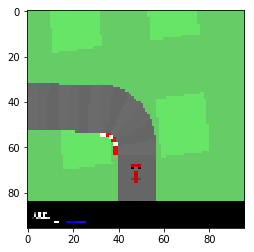

In [71]:
import matplotlib.pyplot as plt
i=30
plt.imshow(X[i])
print(y[i])
